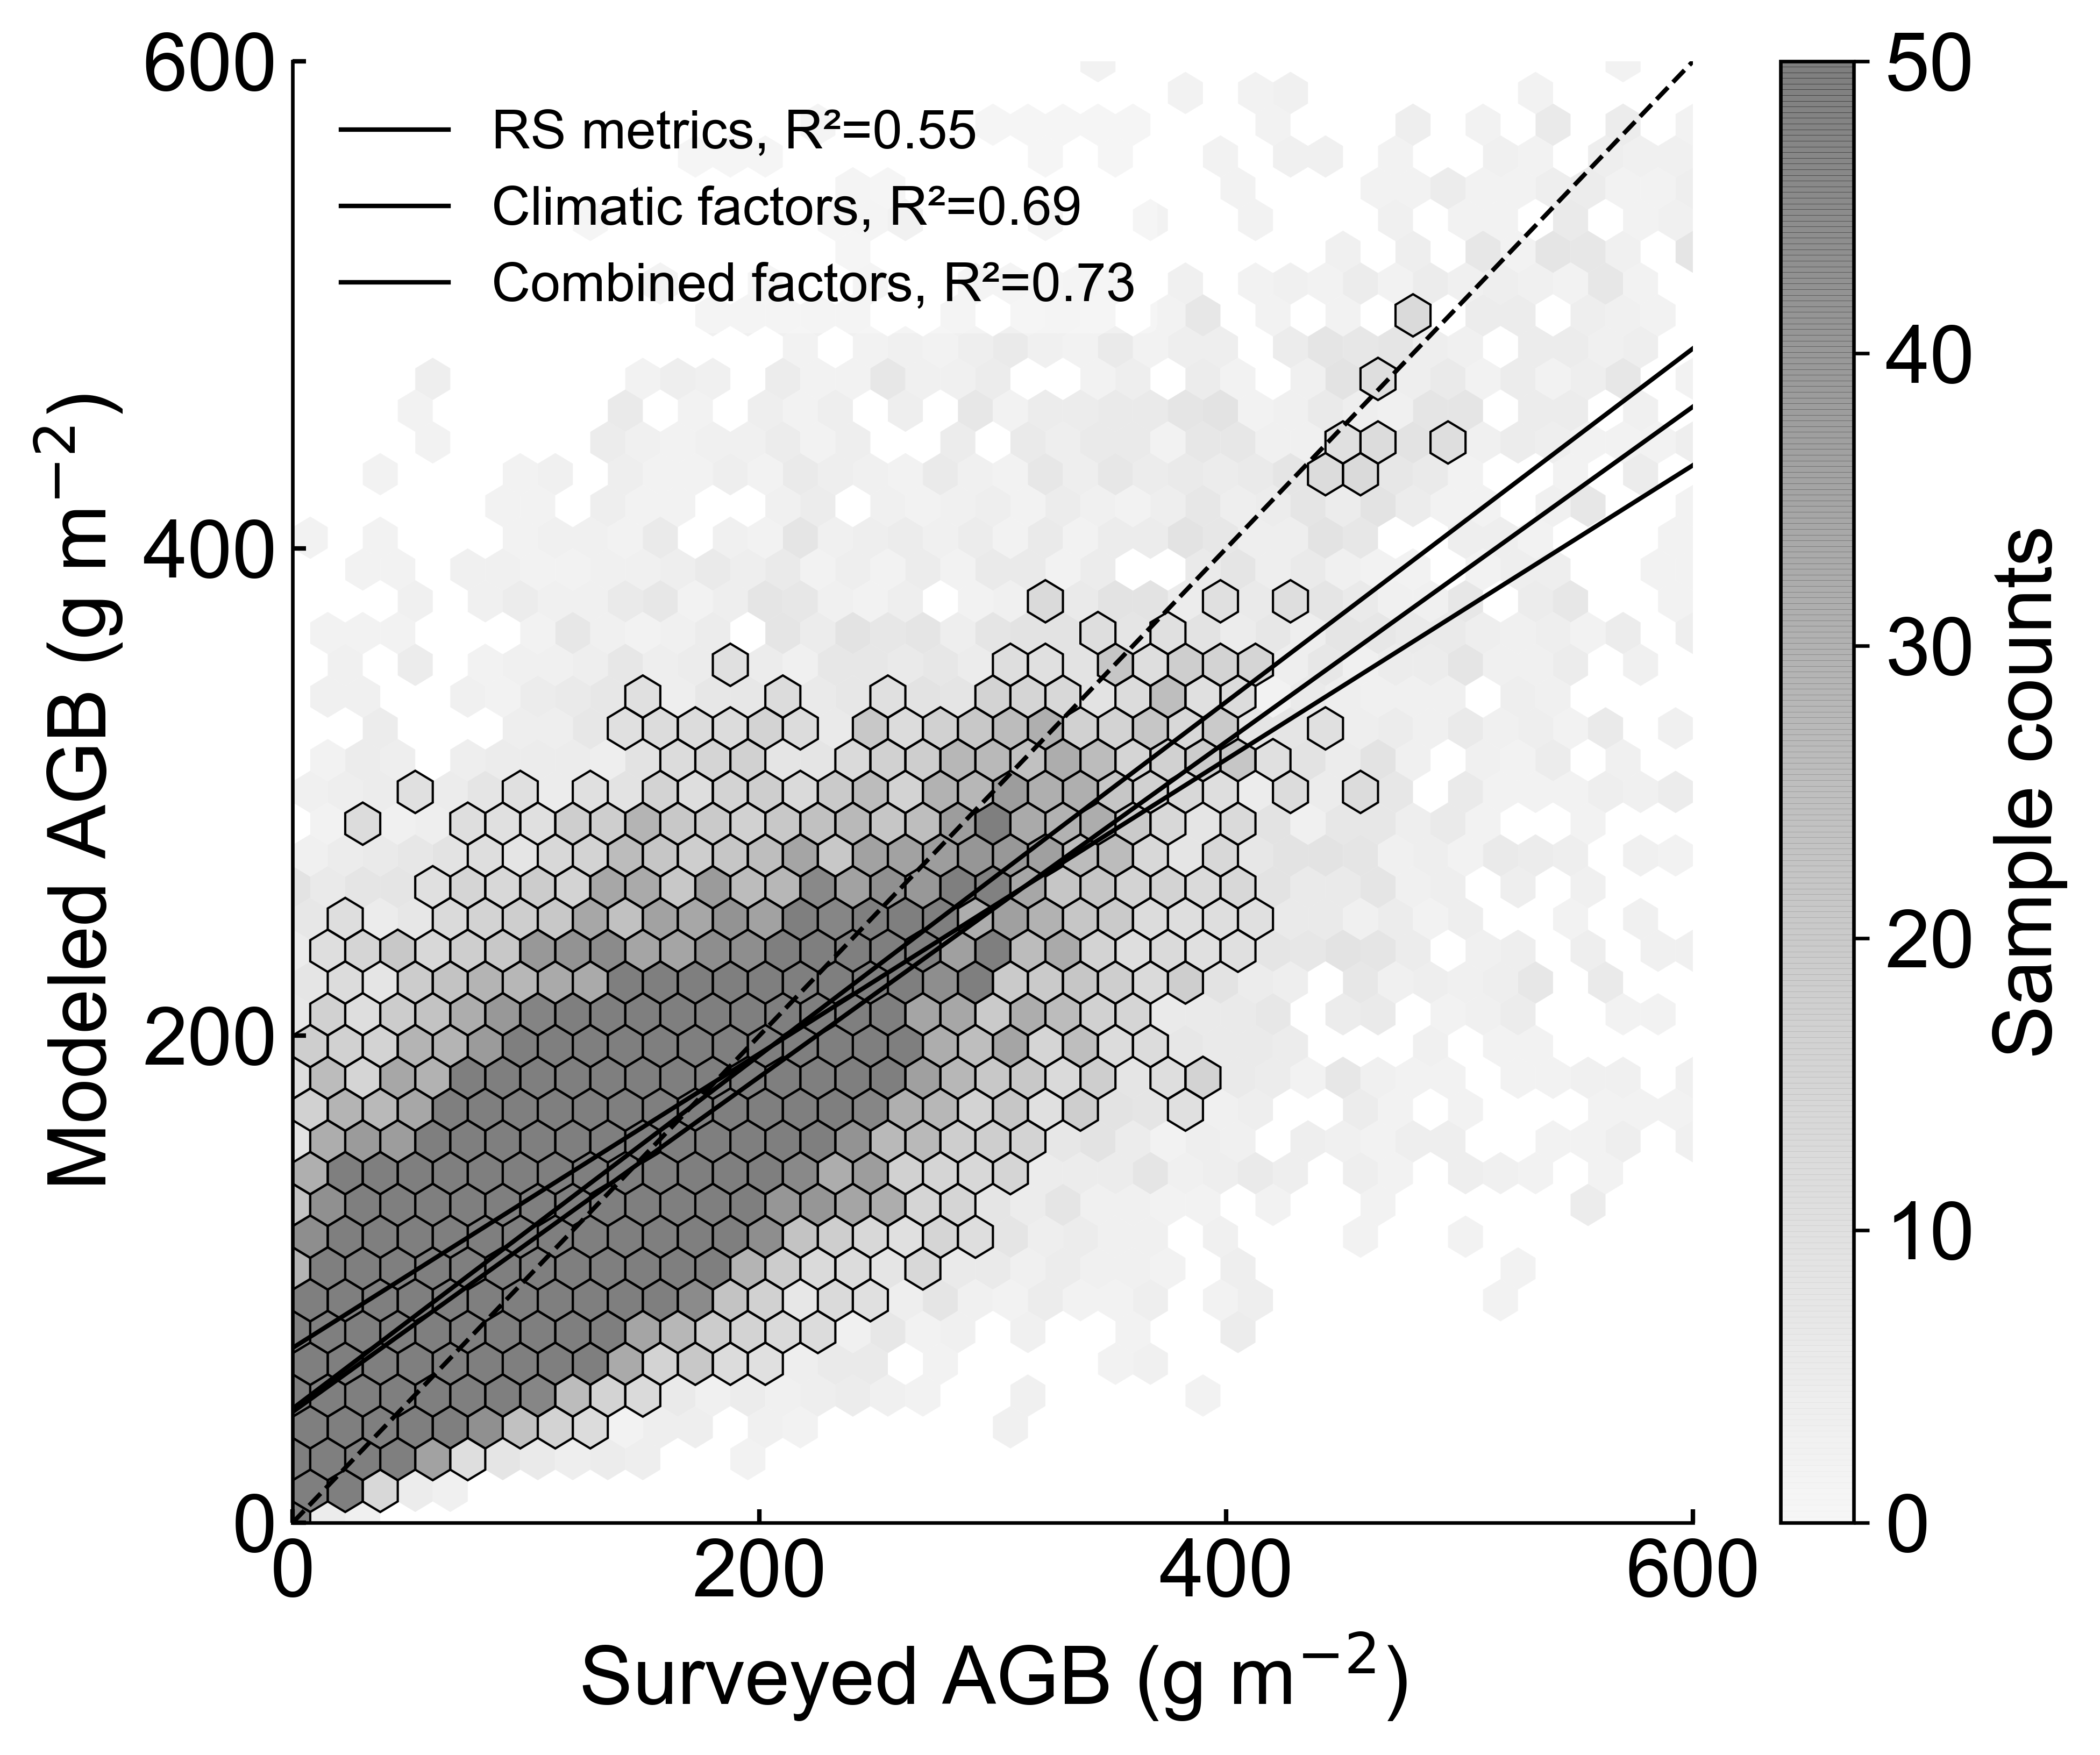

In [8]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set global font
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 15

# Define a reusable modeling function
def process_model(data_test, drop_columns):
    max_r2 = -float('inf')
    best_model_params = {}
    best_model = None
    best_X_test = None
    best_y_test = None
    best_predictions = None

    for threshold in range(450, 470, 50):
        # Create classification column
        data_test['AGB_C'] = (data_test['AGB'] > threshold).astype(int)

        # Extract features and labels
        xtest = data_test.drop(columns=drop_columns)
        ytest = data_test["AGB"]
        ytest_c = data_test["AGB_C"]

        # Drop NaNs
        xtest = xtest.dropna()
        ytest = ytest.loc[xtest.index]
        ytest_c = ytest_c.loc[xtest.index]

        # Split into training and testing
        X_train, X_test, y_train, y_test, y_train_c, y_test_c = train_test_split(xtest, ytest, ytest_c, test_size=0.2, random_state=42)

        # Apply RandomOverSampler to address imbalance
        ros = RandomOverSampler(random_state=42)
        X_train_resampled, y_train_c_resampled = ros.fit_resample(X_train, y_train_c)

        # Restore AGB values for sampled indices
        y_train_resampled = y_train.iloc[ros.sample_indices_].reset_index(drop=True)
        data_resampled = pd.concat([X_train_resampled, y_train_resampled], axis=1)

        # Define and train RF model
        current_model = RandomForestRegressor(
            max_depth=30, 
            min_samples_leaf=1, 
            min_samples_split=2, 
            n_estimators=177, 
            random_state=42, 
            n_jobs=-1
        )
        current_model.fit(data_resampled.drop(columns='AGB'), data_resampled['AGB'])

        # Collect predictions from all trees
        tree_predictions = np.array([tree.predict(X_test) for tree in current_model.estimators_])

        # Define prior and smoothing parameters
        smoothing_parameters = [10]
        prior_means = [48]

        best_r2_temp = -float('inf')
        best_m_temp = None
        best_prior_mean_temp = None

        # Grid search for best Bayesian averaging result
        for prior_mean in prior_means:
            for m in smoothing_parameters:
                bayesian_predictions = (tree_predictions.sum(axis=0) + m * prior_mean) / (tree_predictions.shape[0] + m)
                r2 = r2_score(y_test, bayesian_predictions)
                if r2 > best_r2_temp:
                    best_r2_temp = r2
                    best_m_temp = m
                    best_prior_mean_temp = prior_mean

        # Save best model output
        if best_r2_temp > max_r2:
            max_r2 = best_r2_temp
            best_model_params = {
                'best_r2': best_r2_temp,
                'best_m': best_m_temp,
                'best_prior_mean': best_prior_mean_temp
            }
            best_model = current_model
            best_X_test = X_test
            best_y_test = y_test
            best_predictions = bayesian_predictions

    return best_X_test, best_y_test, best_predictions, best_model_params

# Load data and run modeling for three scenarios
data_test_rs_climate = pd.read_excel('C:\\Users\\LHQ\\Desktop\\Grassland_newdata.xlsx', sheet_name='Sheet2_corrected')
drop_columns_rs_climate = ["INDEX", 'year', "DayOfYear", "lon", "lat", 'Grasstype_18types', "AGB", "YY", "AGB_C","ca"]
X_test_rs_climate, y_test_rs_climate, predictions_rs_climate, model_params_rs_climate = process_model(data_test_rs_climate, drop_columns_rs_climate)

data_test_rs = pd.read_excel('C:\\Users\\LHQ\\Desktop\\Grassland_newdata.xlsx', sheet_name='Sheet2_corrected')
drop_columns_rs = ["INDEX", 'year', "DayOfYear", "lon", "lat", 'Grasstype_18types', "AGB", "YY", "MAP","PreAno","AGB_C","MAS", "MAT", "MAV", "TaAno", "VPDAno", "SSRAno", "PreGS", "TaGS", "VPDGS", "SSRGS", "PreGSAno", "TaGSAno", "VPDGSAno", "SSRGSAno", "DEM", "Slope", "Aspect", "cfvo", "clay", "sand","ca"]
X_test_rs, y_test_rs, predictions_rs, model_params_rs = process_model(data_test_rs, drop_columns_rs)

data_test_climate = pd.read_excel('C:\\Users\\LHQ\\Desktop\\Grassland_newdata.xlsx', sheet_name='Sheet2_corrected_800')
drop_columns_climate = ["INDEX", 'year', "DayOfYear", "lon", "lat", 'Grasstype_18types', "AGB", "YY", "MAP","PreGS","AGB_C","sur_refl_b01", "sur_refl_b02", "sur_refl_b03", "sur_refl_b04", "sur_refl_b05", "sur_refl_b06", "sur_refl_b07", "NDVI", "EVI", "EVI2", "NIRv","ca"]
X_test_climate, y_test_climate, predictions_climate, model_params_climate = process_model(data_test_climate, drop_columns_climate)

# ----------- Begin Hexbin Density Plot with Annotations ---------------

import matplotlib.colors as mcolors
from shapely.geometry import Point
from matplotlib.patches import Polygon as MplPolygon
from scipy.spatial import KDTree
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.font_manager import FontProperties

# Set global font
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 18

# Define plot range
extent = [0, 600, 0, 600]

# Combine all model predictions and true values
all_y = np.concatenate([y_test_rs, y_test_climate, y_test_rs_climate])
all_predictions = np.concatenate([predictions_rs, predictions_climate, predictions_rs_climate])

# Create plot
plt.figure(figsize=(7, 6), dpi=600)

# Normalize color scale
norm = mcolors.Normalize(vmin=0, vmax=50)

# Custom grayscale color map
colors = ["#f0f0f0", "#808080", "#000000"]
custom_gray_cmap = LinearSegmentedColormap.from_list("custom_gray", colors)

# Plot hexbin
hb = plt.hexbin(all_y, all_predictions, gridsize=40, cmap=custom_gray_cmap, mincnt=2, alpha=0.5, extent=extent, edgecolors='none', norm=norm)

# Get hexbin values and coordinates
counts = hb.get_array()
verts = hb.get_offsets()
hex_vertices = hb.get_paths()[0].vertices

# Select high-density hexagons
mask = counts >= 10
high_density_points = verts[mask]

# Build spatial index for neighbor search
tree = KDTree(high_density_points)
hex_distance = np.linalg.norm(hex_vertices[0] - hex_vertices[1])

# Draw hexagon borders
drawn_hexagons = {}
for point in high_density_points:
    hexagon = MplPolygon(hex_vertices + point, edgecolor='black', fill=None, linewidth=0.5)
    plt.gca().add_patch(hexagon)
    drawn_hexagons[tuple(point)] = hexagon

# Remove borders if surrounded by neighbors
for point in list(drawn_hexagons.keys()):
    indices = tree.query_ball_point(point, r=hex_distance * 1.1)
    neighbors = [high_density_points[i] for i in indices if tuple(high_density_points[i]) in drawn_hexagons]
    if len(neighbors) > 5:
        hex_to_remove = drawn_hexagons.pop(tuple(point))
        hex_to_remove.set_edgecolor('none')

# Add colorbar
cb = plt.colorbar(hb, label='Sample counts')
cb.set_alpha(0.5)
cb.draw_all()

# Add linear regression lines
slope, intercept = np.polyfit(y_test_rs, predictions_rs, 1)
plt.plot(np.linspace(0, 600, 100), slope * np.linspace(0, 600, 100) + intercept, color='black', linestyle='-', linewidth=1,
         label=f'RS metrics, R²={r2_score(y_test_rs, predictions_rs):.2f}')

slope, intercept = np.polyfit(y_test_climate, predictions_climate, 1)
plt.plot(np.linspace(0, 600, 100), slope * np.linspace(0, 600, 100) + intercept, color='black', linestyle='-', linewidth=1,
         label=f'Climatic factors, R²={r2_score(y_test_climate, predictions_climate):.2f}')

slope, intercept = np.polyfit(y_test_rs_climate, predictions_rs_climate, 1)
plt.plot(np.linspace(0, 600, 100), slope * np.linspace(0, 600, 100) + intercept, color='black', linestyle='-', linewidth=1,
         label=f'Combined factors, R²={r2_score(y_test_rs_climate, predictions_rs_climate):.2f}')

# Plot 1:1 reference line
plt.plot(np.linspace(0, 600, 100), np.linspace(0, 600, 100), color="black", linestyle='--', linewidth=1)

# Axis settings
plt.xlim(0, 600)
plt.ylim(0, 600)
plt.xticks(range(0, 601, 200), fontsize=18)
plt.yticks(range(0, 601, 200), fontsize=18)
plt.xlabel("Surveyed AGB (g m$^{-2}$)", fontsize=18)
plt.ylabel("Modeled AGB (g m$^{-2}$)", fontsize=18)

# Aesthetic tweaks
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='both', direction='in', length=3, width=1)

# Add legend
font_properties = FontProperties(size=12)
legend = plt.legend(prop=font_properties, loc='upper left')
legend.get_frame().set_alpha(0.3)
legend.get_frame().set_linewidth(0)

# Show plot
plt.show()
